<div class="output_png output_subarea output_execute_result">
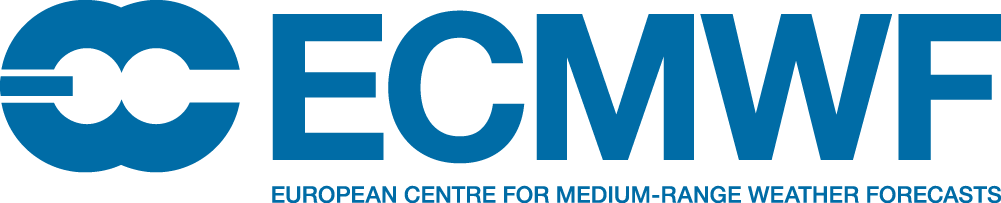
</div>

# 	Rain and mean sea level pressure

This notebook will provide you guidance how to explore and plot ECMWF open dataset to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://charts.ecmwf.int/products/medium-mslp-rain  


<div class="output_png output_subarea output_execute_result">
<center>
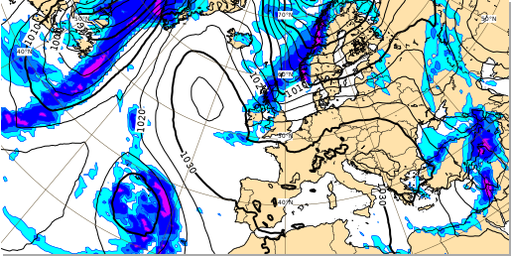</center>
</div>

The full list of available Open data products can be found [here](https://www.ecmwf.int/en/forecasts/datasets/open-data), and more information can be found in the [User documentation](https://confluence.ecmwf.int/display/DAC/ECMWF+open+data%3A+real-time+forecasts+from+IFS+and+AIFS).  

Access to ECMWF Open data is governed by the Creative Commons CC-BY-4.0 licence and associated [Terms of Use](https://apps.ecmwf.int/datasets/licences/general/).  

<sub> In applying this licence, ECMWF does not waive the privileges and immunities granted to it by virtue of its status as an intergovernmental organisation nor does it submit to any jurisdiction </sub>

To find out how to obtain the access to the full forecast dataset at higher resolution please visit our [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input 2 parameters :

* [Mean sea level pressure](https://codes.ecmwf.int/grib/param-db/151)
* [Total precipitation](https://codes.ecmwf.int/grib/param-db/228228)


In this example, we will use: 
- [**ecmwf.opendata**](https://github.com/ecmwf/ecmwf-opendata) Client to download the data
- [**Metview**](https://metview.readthedocs.io/en/latest/) library to read, process and plot the data 

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below, uncomment the code and run the next cell.
</div>

In [1]:
#!pip install earthkit

In [3]:
import earthkit.data as ekd
import earthkit.plots as ekp
import numpy as np
from datetime import timedelta
import xarray as xr
xr.set_options(keep_attrs=True)

In [4]:
parameters = ['msl', 'tp']
filename = 'medium-mslp-rain.grib'
filename

'medium-mslp-rain.grib'

Setting date to 0 will download today's data. 
Removing date and time altogether from the request will download the latest data.  
Try commenting out date and time to download latest forecast!

In [5]:
data = ekd.from_source(
    "ecmwf-open-data",
    date=-1,
    time=0,
    step=[12,24],
    stream="oper",
    type="fc",
    levtype="sfc",
    param=parameters,
    target=filename
)

## Reading and processing the data
The data is already in the memory.

The **describe()** function will give us the overview of the dataset.  

In [6]:
data.describe()

,,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
shortName,typeOfLevel,,,,,,,,,,
msl,meanSea,0,20250727,0,"24,12",None,151,od,oper,fc,0001
tp,surface,0,20250727,0,"24,12",None,228,od,oper,fc,0001


And an overview of one parameter, where we can see more information, such as units or type of level.

In [7]:
data.describe('tp')

shortName,tp
typeOfLevel,surface
level,0
date,20250727
time,0
step,"24,12"
number,None
paramId,228
class,od
stream,oper
type,fc


We can use **ls()** function to list all the fields in the file we downloaded.

In [8]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,msl,meanSea,0,20250727,0,12,fc,None,regular_ll
1,ecmf,tp,surface,0,20250727,0,0-12,fc,None,regular_ll
2,ecmf,msl,meanSea,0,20250727,0,24,fc,None,regular_ll
3,ecmf,tp,surface,0,20250727,0,0-24,fc,None,regular_ll


We can see that we have both parameters at steps 12 and 24.  

If we want to plot the total precipitation between steps 12 24 UTC, we need the data on both timesteps because total precipitation is parameter that is accumulated from the start of the forecast period. This means that step 12 has all accumulated precipitation from start of the forecast (00UTC) until 12 UTC, step 24 has accumulation from 00 to 24 UTC and so on.  
If we want the precipitation from 12 to 24 we need to deaccumulate it, by simply substracting.  
We will use the **select()** function to filter the total precipitation at different steps.

In [9]:
ds = data.to_xarray(engine='cfgrib')

/Users/mamv/Library/jupyterlab-desktop/jlab_server/envs/ekstyles/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [10]:
ds

<xarray.Dataset> Size: 17MB
Dimensions:     (time: 1, step: 2, meanSea: 1, latitude: 721, longitude: 1440,
                 surface: 1)
Coordinates:
  * time        (time) datetime64[ns] 8B 2025-07-27
  * step        (step) timedelta64[ns] 16B 12:00:00 1 days
  * meanSea     (meanSea) float64 8B 0.0
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time  (time, step) datetime64[ns] 16B ...
  * surface     (surface) float64 8B 0.0
Data variables:
    msl         (time, step, meanSea, latitude, longitude) float32 8MB ...
    tp          (time, step, surface, latitude, longitude) float32 8MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-28T16:57 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
tp_12 = ds.tp.sel(step= timedelta(hours=12))
tp_24 = ds.tp.sel(step= timedelta(hours=24))
tp = tp_24 - tp_12
tp

<xarray.DataArray 'tp' (time: 1, surface: 1, latitude: 721, longitude: 1440)> Size: 4MB
array([[[[0.00074768, 0.00074768, 0.00074768, ..., 0.00074768,
          0.00074768, 0.00074768],
         [0.00079346, 0.00079346, 0.00079346, ..., 0.00079346,
          0.00079346, 0.00079346],
         [0.00068665, 0.00068665, 0.00068665, ..., 0.00068665,
          0.00068665, 0.00068665],
         ...,
         [0.00061798, 0.00061035, 0.00061035, ..., 0.00061798,
          0.00061798, 0.00061798],
         [0.00051117, 0.00051117, 0.00051117, ..., 0.00050354,
          0.00050354, 0.00051117],
         [0.00035858, 0.00035858, 0.00035858, ..., 0.00035858,
          0.00035858, 0.00035858]]]],
      shape=(1, 1, 721, 1440), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 8B 2025-07-27
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * surface    (surface) float64 8B 0.0
Attributes: (12/30)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Total precipitation
    GRIB_shortName:                           tp
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown

In [9]:
#tp = tp.squeeze()

In [12]:
msl = data.sel(shortName= 'msl', step = 24)
msl.describe()

,,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
shortName,typeOfLevel,,,,,,,,,,
msl,meanSea,0,20250727,0,24,None,151,od,oper,fc,0001


Mean sea level pressure data has unites Pa, but we want to plot it in hPa, therefore we need to convert it.

We also need to convert total precipitation from metres to milimetres by multiplying with 1000.

In [12]:
#tp = tp * 1000

## Plotting the data
And finally, we can plot the data on the map. 

In [13]:
msl_line = ekp.styles.Style(
    levels={"step": 4, "reference": 1000},
    linecolors="red",
    linewidths=[0.5, 1, 0.5, 0.5],
    units="hPa"
)
msl_style = ekp.styles.Contour(colors=['black'], 
              linewidths= [0.5, 0.5, 0.5, 1], 
              legend_style = None,
              labels = True)

In [14]:
hex_colours = [
    '#00ffff',
    '#0080ff',
    '#0000ff',
    '#d900ff',
    '#ff00ff',
    '#ff8000',
    '#ff0000',
    '#333333',
]
tp_shade = ekp.styles.Style(
    colors = hex_colours,
    levels = [0.5, 2, 4, 10, 25, 50, 100, 250],
    units = "mm",
    extend = "max",
)

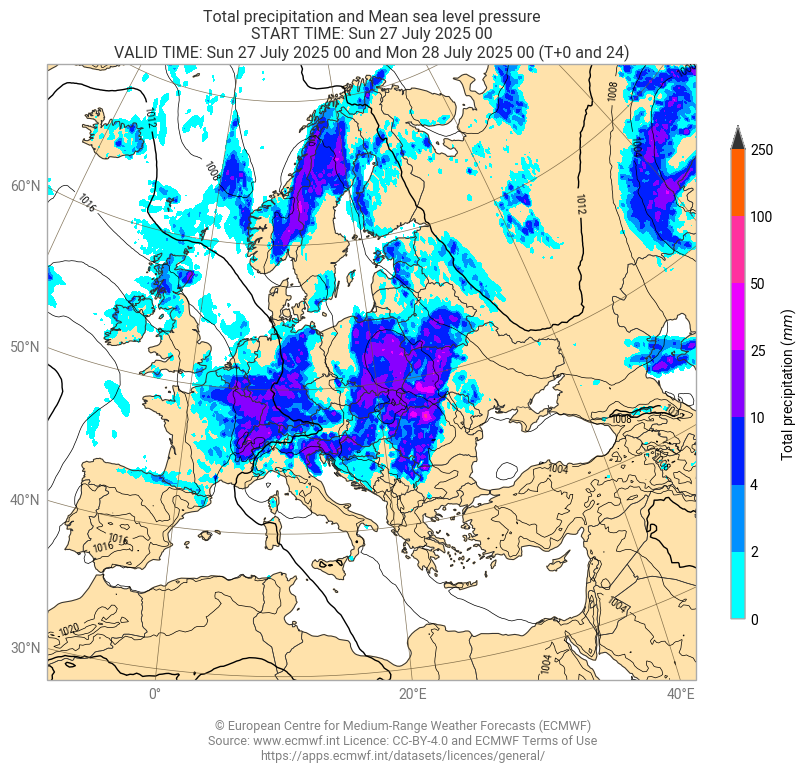

In [17]:
chart = ekp.Map(domain="Europe")

chart.land(color="#ffe2ab")
chart.contourf(tp, style= tp_shade)
chart.legend(location="right", format="%.0f")

#chart.contour(msl, msl_style)

chart.contour(msl,     
               levels={"step": 4, "reference": 1000},
               linecolors="black",
               linewidths=[0.5, 1, 0.5, 0.5],
               labels = True,
               units="hPa", transform_first=True)



chart.title(
    "{variable_name!0} and {variable_name!1}\n"
    "START TIME: {base_time:%a %d %B %Y %H}\n"
    "VALID TIME: {valid_time:%a %d %B %Y %H} (T+{lead_time})",
    fontsize=11.5,
)

chart.coastlines(color="#333333")

chart.borders(color="#333333")
chart.gridlines(color="#665433")

chart.add_attribution("© European Centre for Medium-Range Weather Forecasts (ECMWF)\n" 
                  "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use\n"
                   "https://apps.ecmwf.int/datasets/licences/general/")

#chart.show()
chart.save(fname = 'medium-mslp-rain.png')

To generate the png file you can run the following cell.

In [14]:
png = mv.png_output(
      output_name = "medium-mslp-rain",   # specify relative or full path
      output_title = "medium-mslp-rain",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, tp, tp_shade, msl, msl_shade, title, ecmwf_text)

Note that plot produced using open data dataset will slightly differ from one from Open Charts. This is due to different resolution of the data.  
Open data is on 0.25x0.25 resolution, while high resolution data is 0.1x0.1 grid.